## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/protein/protein_klek_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_klek_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_klek_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train = df_train_all['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

In [5]:
X_train.shape, y_train.shape

((2130, 4860), (2130,))

In [6]:
X_test.shape, y_test.shape

((533, 4860), (533,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,KRFP25,...,KRFP4821,KRFP4823,KRFP4824,KRFP4826,KRFP4827,KRFP4829,KRFP4834,KRFP4843,KRFP4853,KRFP4856
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP18,KRFP19,KRFP20,KRFP25,...,KRFP4821,KRFP4823,KRFP4824,KRFP4826,KRFP4827,KRFP4829,KRFP4834,KRFP4843,KRFP4853,KRFP4856
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
530,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [10]:
# write

with open('../../klek_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['protein'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [10]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'cholesky', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 11.473943920531983
MSE: 253.93731947977636
RMSE: 15.93541086636226
R2 Square 0.44973522753506756 

Base model:
MAE: 11.657542947130775
MSE: 276.5916304798623
RMSE: 16.63104417888012
R2 Square 0.4006448877876445 

Train set:
Tuned model:
MAE: 10.112984329865816
MSE: 211.91929431945167
RMSE: 14.557448070298985
R2 Square 0.5904489337061114 

Base model:
MAE: 11.166091317769439
MSE: 269.902616313355
RMSE: 16.42871316668944
R2 Square 0.4783915043619571 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [12]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8, 12],
    'n_estimators': [500, 1000, 1500],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 12, 'n_estimators': 1000} 

Test set:
Tuned model:
MAE: 10.450777738711993
MSE: 256.472345795589
RMSE: 16.014754003592717
R2 Square 0.4442419991993469 

Base model:
MAE: 10.26687260182041
MSE: 251.91176400046788
RMSE: 15.871728450312773
R2 Square 0.4541244674751448 

Train set:
Tuned model:
MAE: 8.123298463622662
MSE: 144.4179181916804
RMSE: 12.017400642055685
R2 Square 0.7209007675431971 

Base model:
MAE: 7.695375620511819
MSE: 128.8060624338838
RMSE: 11.34927585504396
R2 Square 0.751071933377648 



In [13]:
params = {'max_depth': 12, 'n_estimators': 1000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 10.450777738711993
MSE: 256.472345795589
RMSE: 16.014754003592717
R2 Square 0.4442419991993469 

Train set:
MAE: 8.123298463622662
MSE: 144.4179181916804
RMSE: 12.017400642055685
R2 Square 0.7209007675431971 



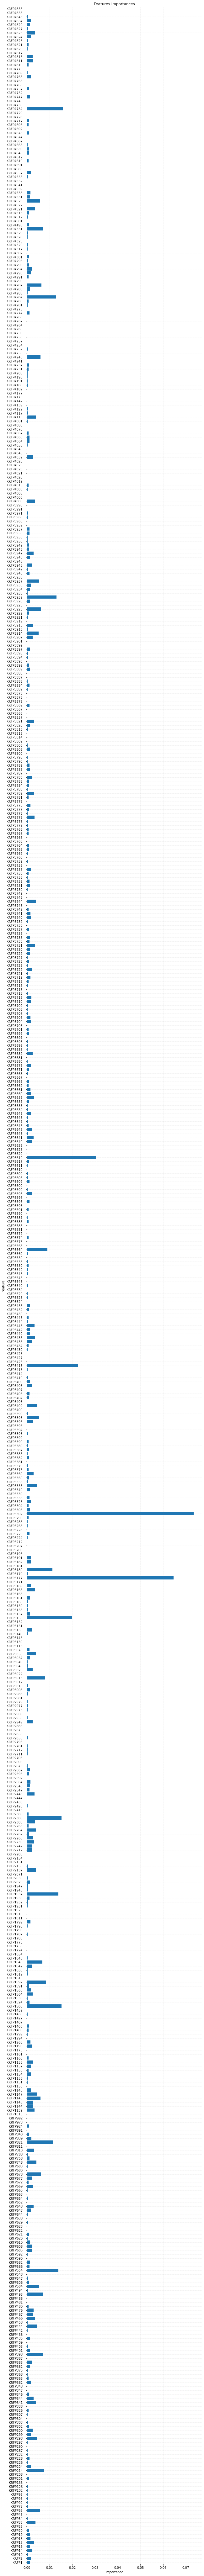

In [14]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [20]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [90, 95, 100],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 10.202828580720338
MSE: 230.20220101270687
RMSE: 15.17241579356125
R2 Square 0.5011676030105059 

Base model:
MAE: 8.988627666103012
MSE: 224.2282522487954
RMSE: 14.974252977988431
R2 Square 0.514112740668985 

Train set:
Tuned model:
MAE: 8.638923439234075
MSE: 173.40857156844768
RMSE: 13.168468839179734
R2 Square 0.6648740001780995 

Base model:
MAE: 3.8049950406411446
MSE: 35.83965449186226
RMSE: 5.98662296222689
R2 Square 0.9307369875882063 



In [21]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 10.202828580720338
MSE: 230.20220101270687
RMSE: 15.17241579356125
R2 Square 0.5011676030105059 

Train set:
MAE: 8.638923439234075
MSE: 173.40857156844768
RMSE: 13.168468839179734
R2 Square 0.6648740001780995 



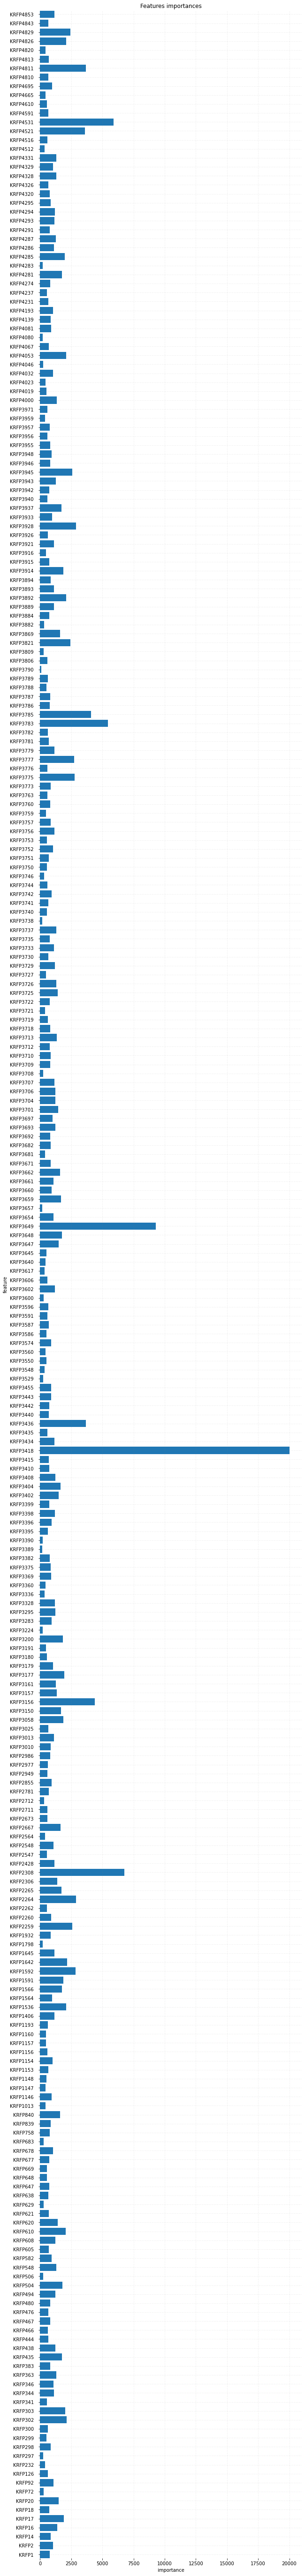

In [22]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [23]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168


## 5.4. LightGBM

Better results - third model.

In [26]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000],
    'min_child_samples': [55, 65, 85, 95],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 9.918731142155186
MSE: 218.65538161783027
RMSE: 14.787000426652806
R2 Square 0.5261887694937627 

Base model:
MAE: 8.999539004226518
MSE: 194.88640178098134
RMSE: 13.960171982500121
R2 Square 0.577694520237457 

Train set:
Tuned model:
MAE: 8.093025149835272
MSE: 152.68191692914164
RMSE: 12.356452441099009
R2 Square 0.7049299258808202 

Base model:
MAE: 5.489403717204601
MSE: 74.40413239500626
RMSE: 8.625783001850108
R2 Square 0.8562080349648962 



In [27]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 9.89525436680737
MSE: 218.17243863337956
RMSE: 14.770661414892007
R2 Square 0.5272352738515969 

Train set:
MAE: 8.100528717707373
MSE: 152.36435206402493
RMSE: 12.343595588969404
R2 Square 0.7055436455024511 



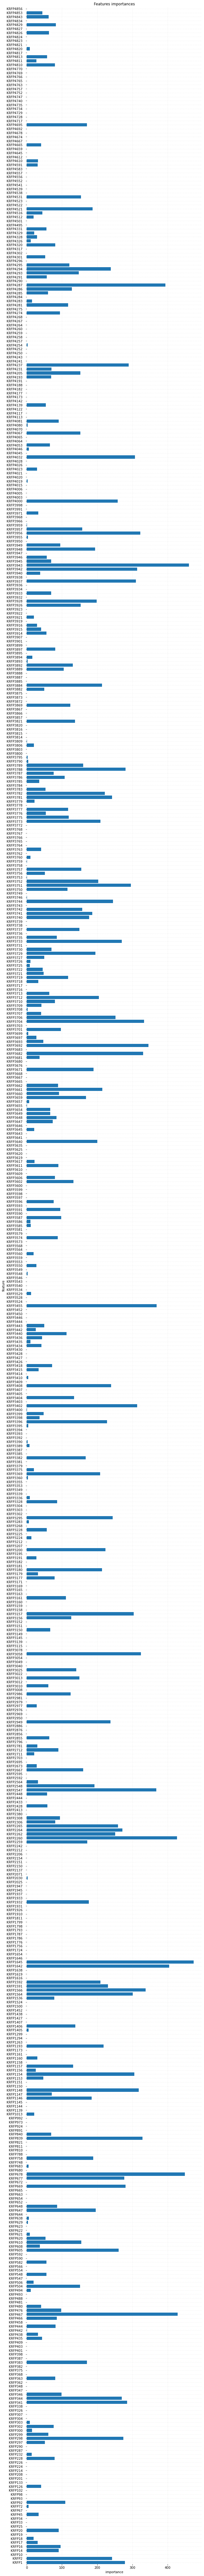

In [31]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [29]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [34]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 3, 5],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[5, 10, 15],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 9.914586332537327
MSE: 230.65831200706643
RMSE: 15.187439284061893
R2 Square 0.5001792417367704 

Base model:
MAE: 8.999539007172077
MSE: 194.88640175271186
RMSE: 13.960171981487616
R2 Square 0.577694520298715 

Train set:
Tuned model:
MAE: 7.709682064467876
MSE: 145.85438947755986
RMSE: 12.0770190642211
R2 Square 0.7181246713471345 

Base model:
MAE: 5.489403724166311
MSE: 74.40413251571644
RMSE: 8.625783008847165
R2 Square 0.856208034731614 



In [35]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 9.914586332537327
MSE: 230.65831200706643
RMSE: 15.187439284061893
R2 Square 0.5001792417367704 

Train set:
MAE: 7.709682064467876
MSE: 145.85438947755986
RMSE: 12.0770190642211
R2 Square 0.7181246713471345 



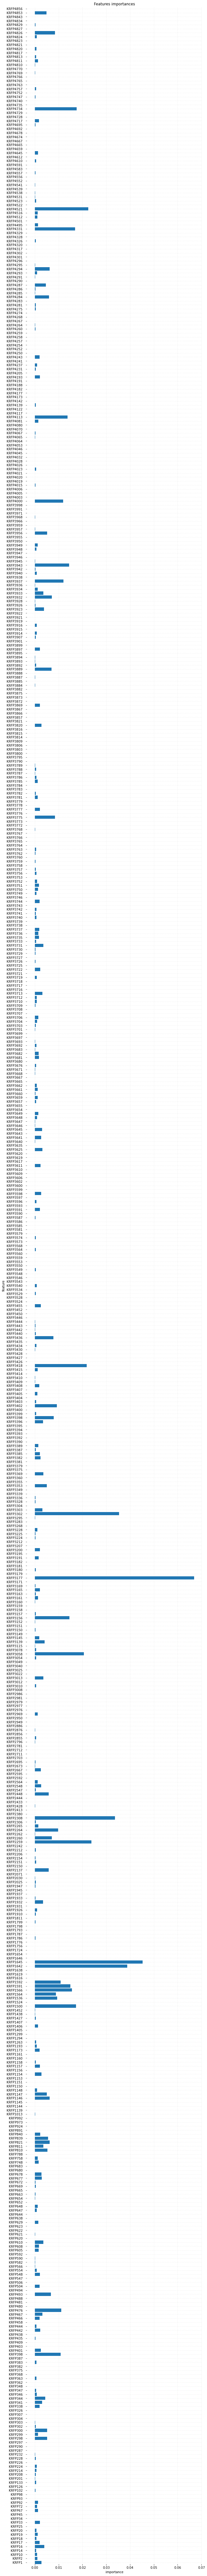

In [36]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [37]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235
4,HistGradient Boosting Regressor,9.914586,230.658312,15.187439,0.500179


## 5.6. Support Vector Regression

Better results - fifth model.

In [40]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [15.0, 20.0, 30.0],
    'epsilon': [2.8, 3.8, 4.8, 6.8],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 9.60632223096186
MSE: 219.69770158430183
RMSE: 14.822202993627561
R2 Square 0.5239301335423352 

Base model:
MAE: 10.706350259652842
MSE: 470.5857412011365
RMSE: 21.692988295786648
R2 Square -0.01972705838500266 

Train set:
Tuned model:
MAE: 7.756505894983014
MSE: 157.17174791505937
RMSE: 12.536815700769449
R2 Square 0.6962529666937531 

Base model:
MAE: 11.042580295089689
MSE: 523.2393232462115
RMSE: 22.87442509105336
R2 Square -0.011202040147172188 



In [41]:
params = {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 9.60632223096186
MSE: 219.69770158430183
RMSE: 14.822202993627561
R2 Square 0.5239301335423352 

Train set:
MAE: 7.756505894983014
MSE: 157.17174791505937
RMSE: 12.536815700769449
R2 Square 0.6962529666937531 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [42]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235
4,HistGradient Boosting Regressor,9.914586,230.658312,15.187439,0.500179
5,Support Vector Regression,9.606322,219.697702,14.822203,0.523930


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [43]:
def average_predictions(X):
    return ((0.10 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.25 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 9.592089921221122
MSE: 215.5885922547601
RMSE: 14.682935410017988
R2 Square 0.5328342919184493 

Train set:
MAE: 7.706031491866441
MSE: 145.73572744426613
RMSE: 12.072105344316133
R2 Square 0.7183539952622604 



In [44]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235
4,HistGradient Boosting Regressor,9.914586,230.658312,15.187439,0.500179
5,Support Vector Regression,9.606322,219.697702,14.822203,0.523930
6,Averaging base models,9.592090,215.588592,14.682935,0.532834


### Averaging base models with Meta-model

In [45]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [46]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,92.494627,88.296059,88.922773,88.505097,83.199951
1,94.269958,94.229828,92.328847,94.943820,94.770657
2,93.507707,95.135994,98.255069,90.604291,92.699819
3,93.277842,94.198761,96.217999,99.335379,99.528933
4,91.503710,90.419312,93.232918,92.752033,91.141097
...,...,...,...,...,...
2125,92.039878,90.820259,90.093886,90.750522,90.999779
2126,90.313899,86.316475,84.673760,93.535509,92.199789
2127,94.063717,98.213776,96.378832,96.427413,98.195066
2128,86.422459,76.280464,74.254500,81.811581,72.977779


In [47]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 9.345850699593335
MSE: 208.22741334078611
RMSE: 14.430087087082535
R2 Square 0.548785462264225 

Train set:
MAE: 6.369551493496892
MSE: 100.10176765684633
RMSE: 10.005087088918634
R2 Square 0.8065452897367378 



In [48]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235
4,HistGradient Boosting Regressor,9.914586,230.658312,15.187439,0.500179
5,Support Vector Regression,9.606322,219.697702,14.822203,0.523930
6,Averaging base models,9.592090,215.588592,14.682935,0.532834
7,Base models + Meta-model,9.345851,208.227413,14.430087,0.548785


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [49]:
params_rf = {'max_depth': 12, 'n_estimators': 1000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9}

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 85, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10}  

params_svr = {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [50]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 314.26601179298933
Model1 R2: 0.37681273792373315
Model2 MSE: 285.345994914068
Model2 R2: 0.4341609253244314
Model3 MSE: 274.6689275774226
Model3 R2: 0.4553334737733262
Model4 MSE: 286.6370105497518
Model4 R2: 0.4316008505180302
Model5 MSE: 283.0457481177374
Model5 R2: 0.438722298331097
Average MSE = 288.79273859039387
Average R2 = 0.42732605717412364
-------------- fold 2 --------------
Model1 MSE: 330.816468840795
Model1 R2: 0.3851443333390733
Model2 MSE: 304.1199004812107
Model2 R2: 0.4347625896302697
Model3 MSE: 286.1472136506559
Model3 R2: 0.468166635026229
Model4 MSE: 304.13181536894393
Model4 R2: 0.4347404446135297
Model5 MSE: 300.2874770043532
Model5 R2: 0.44188553396265795
Average MSE = 305.10057506919173
Average R2 = 0.43293990731435195
-------------- fold 3 --------------
Model1 MSE: 318.8218843404898
Model1 R2: 0.4274771005007777
Model2 MSE: 316.45829213485575
Model2 R2: 0.4317215100889169
Model3 MSE: 305.5638417713424
Model3

In [51]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [52]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [53]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,90.091070,84.821907,87.884026,88.729060,80.605871
1,93.570852,96.181404,94.704590,96.444588,94.017857
2,94.088369,91.963959,94.841607,91.593689,89.988143
3,91.625950,91.396751,91.566427,99.958085,95.135503
4,91.581817,88.408112,88.362284,90.981691,86.982352
...,...,...,...,...,...
2125,92.949300,92.409515,90.865919,92.647406,90.784730
2126,90.556701,83.174591,82.688026,95.894807,82.822275
2127,93.277392,96.097641,95.672700,94.477188,97.503013
2128,87.481834,80.697922,78.641198,81.380742,78.257304


In [54]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,87.806253,95.510256,95.537635,92.225089,90.326598
1,91.118877,84.155824,84.800964,89.342771,88.326528
2,89.619120,83.242360,85.182047,83.911342,89.643995
3,94.134058,94.367222,94.817967,95.438760,91.666013
4,83.792471,78.843234,79.465602,73.600517,79.589805
...,...,...,...,...,...
528,85.649793,103.515018,102.675364,79.799398,93.046419
529,93.815205,89.227093,90.422225,96.065131,91.209232
530,91.331622,86.773540,87.131284,89.157570,87.828914
531,92.094804,94.344851,95.205663,90.236915,86.502845


In [55]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 9.19913036797
MSE: 205.68173185926338
RMSE: 14.341608412561799
R2 Square 0.5543017796139867 

Train set:
MAE: 10.088797294486582
MSE: 258.0918198805571
RMSE: 16.065236377985762
R2 Square 0.5012168175943654 



In [56]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,11.473944,253.937319,15.935411,0.449735
1,Random Forest Regressor,10.450778,256.472346,16.014754,0.444242
2,XGBoost,10.202829,230.202201,15.172416,0.501168
3,LightGBM,9.895254,218.172439,14.770661,0.527235
4,HistGradient Boosting Regressor,9.914586,230.658312,15.187439,0.500179
5,Support Vector Regression,9.606322,219.697702,14.822203,0.523930
6,Averaging base models,9.592090,215.588592,14.682935,0.532834
7,Base models + Meta-model,9.345851,208.227413,14.430087,0.548785
8,Base models + Meta-model + cv,9.199130,205.681732,14.341608,0.554302
